In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

## homework 4

in the code below I pre-process the data to create normalized inputs,
but I then keep only the temperature and create randomly selected sequences of 10 to 24 hour segments + the temperature in the next hour after the sequence

the homework:

1. create a neural network that will predict the temperature in the next hour based on the previous n hours (where n is not constant)
2. train the network
3. report your performance on random sequences from the test dataset (in terms of mean absolute error) (submit your notebook and write in the email what the final MAE is)

4. bonus, if you want to dive deeper: work with the other variables in the dataset, and see if it improves your predictive powers.
5. bonus 2, try to predict more than 1 hour ahead

In [5]:
df = pd.read_csv('climate_hour.csv')

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [7]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [8]:
len(df)

70037

In [9]:
train_df = df.iloc[0:50000].copy()
valid_df = df.iloc[50000:60000].copy()
test_df = df.iloc[60000:].copy()

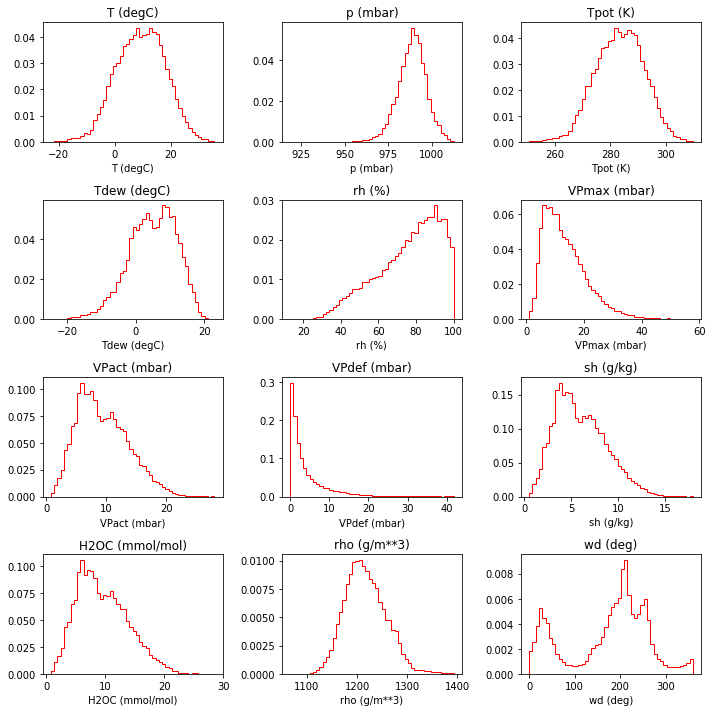

In [10]:
variables = [ 'T (degC)','p (mbar)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)',
       'wd (deg)']


mean_and_std = {}


fig, ax = plt.subplots(4,3,figsize=(10,10))

varindex = -1
for axlist in ax:
    for ax_i in axlist:
        varindex+=1
        varname = variables[varindex]
        
        h = ax_i.hist(train_df[varname],
                      bins=50,histtype='step',edgecolor='r',density=True)
        
        mean_and_std[varname] = [np.mean(train_df[varname]),np.std(train_df[varname])]
        #ax_i.legend()
        ax_i.set_title(varname)
        ax_i.set_xlabel(varname)
        #ax_i.set_yscale('log')

plt.tight_layout()
plt.show()

In [11]:
mean_and_std

{'T (degC)': [9.227655200000049, 8.629936143559394],
 'p (mbar)': [988.6583043999943, 8.235491297362804],
 'Tpot (K)': [283.3145756000014, 8.699706474122262],
 'Tdew (degC)': [4.73482099999997, 6.9864561683273525],
 'rh (%)': [75.98549279999983, 16.526980500416588],
 'VPmax (mbar)': [13.442387000000084, 7.6695472038596275],
 'VPact (mbar)': [9.445542600000037, 4.232476860844675],
 'VPdef (mbar)': [3.9967386000000387, 4.794622096189584],
 'sh (g/kg)': [5.969679599999997, 2.6866046924219917],
 'H2OC (mmol/mol)': [9.555911200000027, 4.284437455456045],
 'rho (g/m**3)': [1216.4340982000115, 40.83861437520577],
 'wd (deg)': [173.59595519999962, 87.6742550424212]}

In [12]:
def transform_normalize(df,mean_and_std):
    
    for varname in mean_and_std:
        df[varname] = df[varname].apply(lambda x: (x-mean_and_std[varname][0])/mean_and_std[varname][1] )
    
transform_normalize(train_df,mean_and_std)
transform_normalize(valid_df,mean_and_std)
transform_normalize(test_df,mean_and_std)


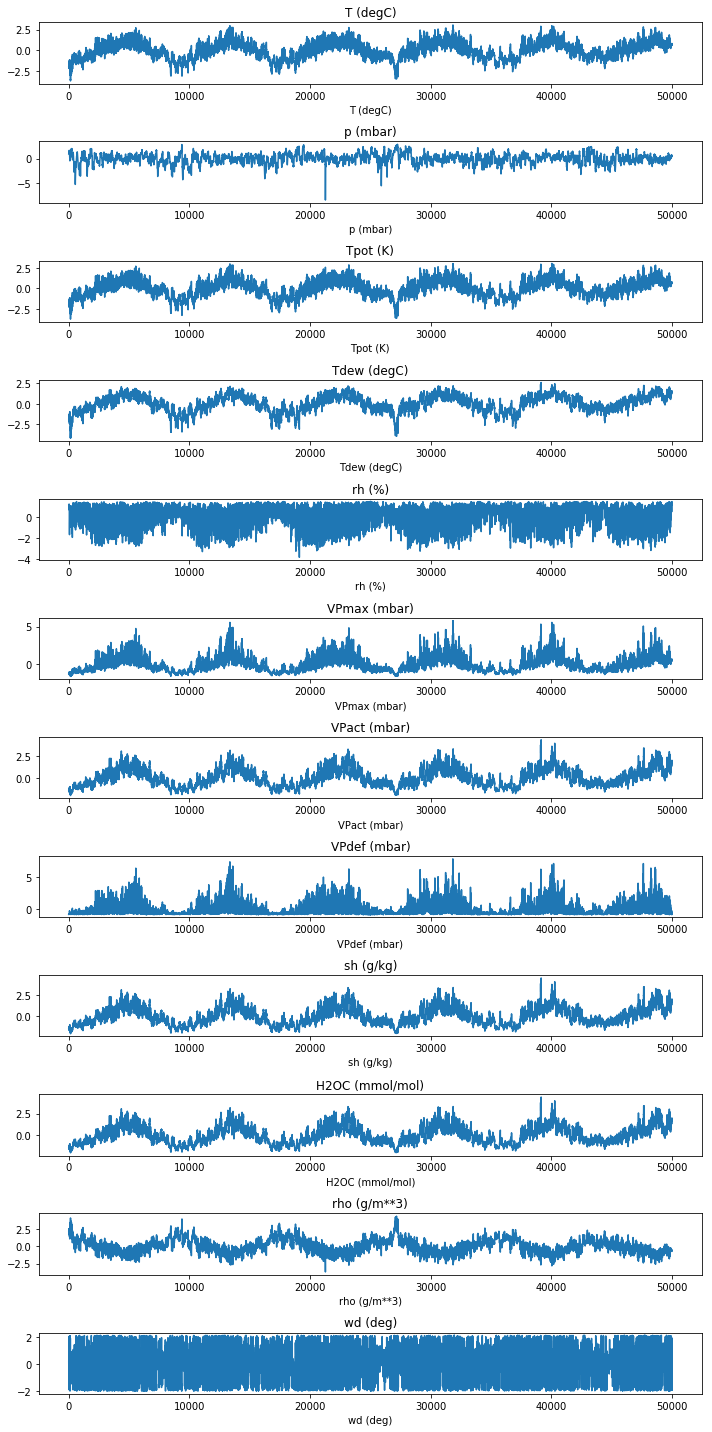

In [13]:
variables = [ 'T (degC)','p (mbar)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)',
       'wd (deg)']

fig, ax = plt.subplots(12,1,figsize=(10,20))

varindex = -1
for ax_i in ax:
    
    varindex+=1
    varname = variables[varindex]

    h = ax_i.plot(train_df[varname])
    
    ax_i.set_title(varname)
    ax_i.set_xlabel(varname)
    

plt.tight_layout()
plt.show()

In [14]:
def collect_sequence(df):
    
    output_length = 1
    
    seq_length = np.random.randint(10,25)
    
    n_entries = len(df)
    
    start_idx = np.random.randint(0,n_entries-output_length-seq_length-1)
    
    input_seq = df.iloc[start_idx:start_idx+seq_length]['T (degC)'].values
    target = df.iloc[start_idx+seq_length: start_idx+seq_length+output_length]['T (degC)'].values
        
    df_i = pd.DataFrame.from_dict({'input': [input_seq], 'target': [target],'seq_length': [seq_length]})
    
    return df_i   

In [15]:
train_df = pd.concat([collect_sequence(train_df) for _ in range(10000)])


In [16]:
valid_df = pd.concat([collect_sequence(valid_df) for _ in range(5000)])

In [17]:
test_df = pd.concat([collect_sequence(test_df) for _ in range(5000)])